## Gravitational Epidemic Model

Goal of this demo is to make a class that represents a metapopulation model spatial unit (i.e. city) undergoing an outbreak. The goal is to extend it to make sample data for some of my other methods. Each object represents a single city that are then linked to other city objects by a list of tuples containing neighboring cities and distance. Once the simulation is started each city will calculate the delta for each compartment based on a gravity-based stochastic SIR model by calculating transition probabilities from a combination of the internal pools and the infected from neighbors at each time point. The number of transitions is then calculated using a binomial distribution:
$$
\begin{aligned}
\lambda_I(i) &= \beta \left( \frac{I_i}{N_i} + \sum_{j \neq i}{\frac{G I_j}{N_j D_{ij}^\alpha}} \right) \\
\Pr_{S \to I}(i) &= 1 - e^{-\lambda_I(i) \Delta t} \\
\Pr_{I \to R}(i) &= 1 - e^{-\gamma \Delta t} \\
\Delta S_i &= -B(S,\Pr_{S \to I}(i)) \\
\Delta I_i &= B(S,\Pr_{S \to I}(i)) - B(I,\Pr_{I \to R}(i)) \\
\Delta R_i &= B(I,\Pr_{I \to R}(i))
\end{aligned}
$$
where $i$ and $j$ are city indices, $\beta$ and $\gamma$ are the base infection and recovery rates respectively, $G$ is a gravitational coeffiecient/mobility term, and $D_{ij}$ is the distance (spatial or time) between $i$ and $j$, and $\alpha$ is a power-law constant for the effect of distance (typically 0.5-3 based on empiric studies and region). Here we will preassign $\beta$, $\gamma$, $G$ and $\alpha$, for simulation purposes, but they should be empirically derived typically for pathogen and spatial region of interest. The class is provided below:

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

#Base parameters, ideally should be fit to data in the future
BETA = 0.25
GAMMA = 1/14.0
DIST_POWER_LAW = 2 
GRAV_CONSTANT = 0.1 #Constant for inter versus intra pool mixing
dt = 1 #Time step in days
rng = np.random.default_rng(seed=17)

class City(object):
    def __init__(self,name,pop_size,immunity = 0,rng_seed=17):
        self.name = name
        self.pop_size = int(pop_size)
        self.I = 0
        self.R = int(round(pop_size * immunity))
        self.S = pop_size - self.R
        self.T = 0 #Current time-step

        self._new_inf = 0
        self._new_rec = 0

        #Make a record of simulation course
        self.series_S = []
        self.series_I = []
        self.series_R = []
        self.series_T = []
        #Incidence is the new infections per time-point (dI/dt or self._new_inf)
        #whereas I is the pool of the currently infectious people
        self.series_incidence = [] 

        self._record()
        self._neighbors = []
    
    #Function to update the series with the current values of each variable
    def _record(self):
        self.series_S.append(self.S)
        self.series_I.append(self.I)
        self.series_R.append(self.R)
        self.series_T.append(self.T)
        self.series_incidence.append(self._new_inf)

    #Starting number of cases, 
    def initial_outbreak(self,n=1):
        if(n > self.S):
            raise ValueError("Outbreak cannot be larger than susceptible pool!")
        self.I = n
        self.S -= n

    def add_neighbor(self, neighbor_city, distance, recurse = True):
        self._neighbors.append((neighbor_city,float(distance)))
        if recurse: #Assuming symmetry, simplify adding the reverse relationship
            neighbor_city.add_neighbor(self,distance,recurse = False)

    def bound_popsize(self,x):
        tmp = min(x,self.pop_size)
        tmp = max(tmp,0)
        return(tmp)

    #This will prepare the time step by calculating the new changes in infection and recoveries
    #We don't want to commit the changes as the other cities need to see the current time point to
    #determine the new infections and recoveries 
    def calculate_deltas(self):
        # --- 1. total infection rate per susceptible ---
        local_rate = BETA * self.I / self.pop_size

        neighbour_rate = 0.0
        for nb, dist in self._neighbors:
            neighbour_rate += GRAV_CONSTANT * BETA * nb.I / (((dist)** DIST_POWER_LAW) * nb.pop_size)

        lam_inf  = (local_rate + neighbour_rate)          # total λ
        p_inf    = 1.0 - math.exp(-lam_inf * dt)          # infection prob

        # --- 2. recovery probability ---
        p_rec    = 1.0 - math.exp(-GAMMA * dt)            # recovery prob
        
        # --- 3. stochastic draws (binomial) to be stroed in temp var ---------------
        self._new_inf  = rng.binomial(self.S, p_inf)         # S → I
        self._new_rec  = rng.binomial(self.I, p_rec)         # I → R
    
    #After all cities have completed calculate_deltas the simulation calls update_counts 
    def update_counts(self):
        self.S -= self._new_inf
        self.I += (self._new_inf - self._new_rec)
        self.R += self._new_rec
        self.T += dt
        self._record()

    #Quick plot of SIR curves
    #ax indicates a prior plot 
    def plot_sir_curves(self, ax=None):
        import matplotlib.pyplot as plt
        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.figure
        ax.plot(self.series_T, self.series_S, label="S")
        ax.plot(self.series_T, self.series_I, label="I")
        ax.plot(self.series_T, self.series_R, label="R")
        ax.set(xlabel="Time", ylabel="Count", title=f"SIR - City: {self.name}")
        ax.legend()
        return fig, ax



We will do a test case now looking at an outbreak in two metro-areas (Chicago and DC). For each metro the primary city (Chicago and Washington) is included as well as several suburbs for each city. We then assign each city its population size and the neighbors. In this example we will assume all cities within a metro are connected to each other and that the two primary cities are connected to each other. Since the primary cities make up the vast population for each of the metro areas here, we will ignore inter-metro suburb connections.

In [2]:
#Chicago area poopulations
POP_A = 150000.
POP_B = 75000.
POP_C = 2600000.
POP_E = 75000.

#DC area populations
POP_D = 680000.
POP_F = 25000.
POP_G = 155230
POP_H = 67403

TIME_STEP = 250

#Chicago Connections
dist_AB = 15.
dist_AC = 40.
dist_AE = 50.
dist_BC = 30.
dist_BE = 40.
dist_CE = 15.

#DC Connections
dist_DF = 19.
dist_DG = 4.
dist_DH = 7.
dist_FG = 14.
dist_FH = 21.
dist_GH = 10

#Inter-metro Connections
dist_CD = 700

city_A = City(name="Aurora, IL",pop_size=POP_A)
city_B = City(name="Bolingbrook, IL",pop_size=POP_B)
city_C = City(name="Chicago, IL",pop_size=POP_C)
city_E = City(name = "Evanston, IL",pop_size=POP_E)

city_A.add_neighbor(city_B,dist_AB)
city_A.add_neighbor(city_C,dist_AC)
city_A.add_neighbor(city_E,dist_AE)
city_B.add_neighbor(city_C,dist_BC)
city_B.add_neighbor(city_E,dist_BE)
city_C.add_neighbor(city_E,dist_CE)

city_D = City(name="Washington, DC",pop_size=POP_D)
city_F = City(name="Fairfax, VA",pop_size=POP_F)
city_G = City(name="Alexandria, VA",pop_size=POP_G)
city_H = City(name="Bethesda, MD",pop_size=POP_H)

city_D.add_neighbor(city_F,dist_DF)
city_D.add_neighbor(city_G,dist_DG)
city_D.add_neighbor(city_H,dist_DH)
city_F.add_neighbor(city_G,dist_FG)
city_F.add_neighbor(city_H,dist_FH)
city_G.add_neighbor(city_G,dist_FH)

city_C.add_neighbor(city_D,dist_CD)


city_list = [city_A, city_B, city_C, city_E, #Chicagoland
             city_D, city_F, city_G, city_H] #DC metro

Once we have finished the initialization step we then place an outbreak in one of the cities. For this example we will start the outbreak in Chicago with 10 cases. We then iterate over time to simulate the outbreak. For each timestep we first run `calculate_deltas` in each city and then we run `update_counts` after all the cities are done to commit the changes.

In [3]:
#Put an initial outbreak case
city_C.initial_outbreak(10)

t = range(TIME_STEP)

for i in t:
    for city in city_list:
        city.calculate_deltas()
    for city in city_list:
        city.update_counts()

Once we have calculated the time series we can plot out the compartments and most importantly for our original purpose, get the incidence function for each city and a total one for the region:

In [4]:
#Make an incidence plot by city
SHOW_INDIVIDUAL_PLOTS = False
if(SHOW_INDIVIDUAL_PLOTS):
    for city in city_list:
        city.plot_sir_curves()
        plt.show()

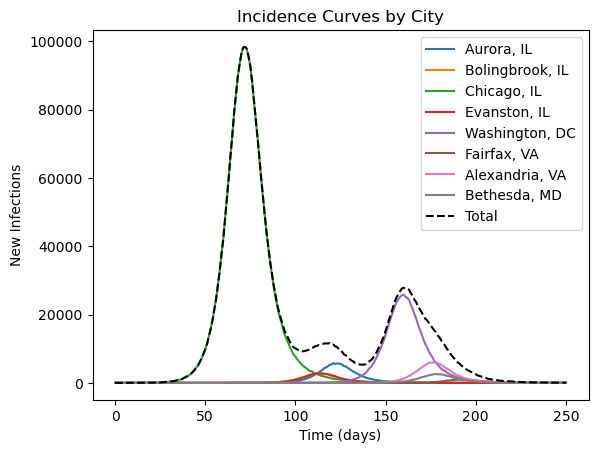

In [5]:
total_incid_arr = np.zeros(len(city_list[0].series_T))
for city in city_list:
    plt.plot(city.series_T,city.series_incidence,label=city.name)
    city_incid_arr =  np.asarray(city.series_incidence)
    total_incid_arr += city_incid_arr
plt.plot(city_list[0].series_T,total_incid_arr,
         label="Total",
         c="black",
         linestyle="--")
plt.title("Incidence Curves by City")
plt.xlabel("Time (days)")
plt.ylabel("New Infections")
plt.legend()


## PNW Example
Let's now make a more comprehensive example where we look at the the Pacific Northwest (PNW) region. We will keep the same infection process but see how differences in scale affect the outcome. We can start with the example of using states as our spatial resolution. Again, even though the class is named "City" we can really use any spatial unit so long as we have a population and can calculate some distance function. For the sake of these examples we will just use Euclidean distance between centroids. 

First let's start with creating 5 spatial units representing Washington, Oregon, Idaho, Montana, and Wyoming. We will download the population data from the census using `censusdata` and use a [pre-downloaded TIGER dataset](https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_500k.zip) for finding state centroids.

In [ ]:
import pandas as pd
import geopandas as gpd
import censusdata as cd #Requires pip install

from math import radians, sin, cos, sqrt, atan2

TIME_STEP = 500
EARTH_RADIUS_KM = 6371.0088  # mean Earth radius

def great_circle_km(lat1, lon1, lat2, lon2, R=EARTH_RADIUS_KM):
    phi1, lam1, phi2, lam2 = map(radians, (lat1, lon1, lat2, lon2))
    dphi = phi2 - phi1
    dlam = lam2 - lam1
    a = sin(dphi / 2) ** 2 + cos(phi1) * cos(phi2) * sin(dlam / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c


# --- inputs ---
state_fips = ["53","41","16","30","56"]  # WA, OR, ID, MT, WY

# 1) Extract the centroid data
rows = []
for s in state_fips:
    df = cd.download('dec/pl', 2020,
                     cd.censusgeo([('state', s)]),
                     ['P1_001N'])
    df = df.reset_index().rename(columns={'index': 'geo', 'P1_001N': 'pop_2020'})
    df['STATEFP'] = s
    rows.append(df)

pop_df = pd.concat(rows, ignore_index=True)

zip_path = "./raw_data/cb_2020_us_state_500k.zip"
g = gpd.read_file(zip_path)

# keep the ones you care about
g = g[['STATEFP', 'NAME', 'geometry']].to_crs(4326)

# use representative_point() to guarantee it's inside the polygon
pts = g.geometry.representative_point()
g['lat'] = pts.y
g['lon'] = pts.x

# 3) Join on STATEFP & add a clean state_name column
df_state = (
    g.merge(pop_df[['STATEFP','pop_2020']], on='STATEFP', how='left')
        .rename(columns={'NAME': 'state_name'})
)
df_state = df_state[df_state["STATEFP"].astype(str).isin(state_fips)].copy()
df_state = df_state[['STATEFP','state_name','pop_2020','lat','lon']]

print(df_state)

pnw_state_list = {
    row.STATEFP: City((row.state_name), 
               row.pop_2020, 0)
    for row in df_state.itertuples(index=False)
}

for row1 in df_state.itertuples(index=False):
    for row2 in df_state.itertuples(index=False):
        if(row1.STATEFP < row2.STATEFP):
            d = great_circle_km(row1.lat,row1.lon,
                                row2.lat,row2.lon)
            if(math.isnan(d)):
                print(f"City #1: {cid1}, {row1.city_name}, {row1.lat},{row1.lon}")
                print(f"City #2: {cid1}, {row2.city_name}, {row2.lat},{row2.lon}")
                raise ValueError("Invalid distance!")
            pnw_state_list[row1.STATEFP].add_neighbor(pnw_state_list[row2.STATEFP],d)



ModuleNotFoundError: No module named 'pandas'

Now that we have the data and initalized the cities we can run the simulation. Again we will start with an outbreak of 10 cases in Washington State. We see the outbreak peak in Washington ends well before the outbreak develops any real foothold in the neighboring states. It spreads to Oregon first and then propagates to Idaho and Montana with the final peak  and then to Wyoming and Montana. There are is minimal overlap between outbreaks except for Idaho and Montana.

In [ ]:
pnw_state_list['53'].initial_outbreak(10)

t = range(TIME_STEP)
for i in t:
    for state in pnw_state_list.values():
        state.calculate_deltas()
    for state in pnw_state_list.values():
        state.update_counts()

total_incid_arr = np.zeros(len(pnw_state_list['53'].series_T))
for state in pnw_state_list.values():
    plt.plot(state.series_T,state.series_incidence,label=state.name)
    state_incid_arr =  np.asarray(state.series_incidence)
    total_incid_arr += state_incid_arr
plt.plot(pnw_state_list['53'].series_T,total_incid_arr,
         label="Total",
         c="black",
         linestyle="--")
plt.title("Incidence Curves by State")
plt.xlabel("Time (days)")
plt.ylabel("New Infections")
plt.legend()
plt.show()

This obviously is a gross over simplification. Realistically travel between states isn't random mixing between the entire populations but typically on the order of cities and counties that have shared economic ties. Therefore we want to set our spatial unit to be municipalities and then re-aggregate the incidence curves at the state level to see if it is able to predict state level burden. We use a [pre-made CSV](https://city-of-vancouver-wa-geo-hub-cityofvancouver.hub.arcgis.com/datasets/8fe7368fd2024ed183572566a8fe96c3/about) with the populations and centroids of all incorporated municipalites. We then repeat the same process as before with the starting 10-case outbreak in Seattle, WA.

In [ ]:
import pandas as pd
from math import radians, sin, cos, sqrt, atan2

TIME_STEP = 500
EARTH_RADIUS_KM = 6371.0088  # mean Earth radius

def great_circle_km(lat1, lon1, lat2, lon2, R=EARTH_RADIUS_KM):
    phi1, lam1, phi2, lam2 = map(radians, (lat1, lon1, lat2, lon2))
    dphi = phi2 - phi1
    dlam = lam2 - lam1
    a = sin(dphi / 2) ** 2 + cos(phi1) * cos(phi2) * sin(dlam / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

pnw_city_csv = pd.read_csv("pnw_cities.csv").set_index("id")
pnw_city_list = {
    cid: City((row.city_name + ", " + row.state), 
               row.pop_size, row.immunity)
    for cid, row in pnw_city_csv.iterrows()
}

for cid1, row1 in pnw_city_csv.iterrows():
    for cid2, row2, in pnw_city_csv.iterrows():
        if(cid2 > cid1):
            d = great_circle_km(row1.lat,row1.lon,
                                row2.lat,row2.lon)
            if(math.isnan(d)):
                print(f"City #1: {cid1}, {row1.city_name}, {row1.lat},{row1.lon}")
                print(f"City #2: {cid1}, {row2.city_name}, {row2.lat},{row2.lon}")
                raise ValueError("Invalid distance!")
            pnw_city_list[cid1].add_neighbor(pnw_city_list[cid2],d)

In [ ]:
index_city = rng.integers(1,len(pnw_city_list)+1)
pnw_city_list[216].initial_outbreak(10)

SHOW_INDIVIDUAL_PLOTS = False

t = range(TIME_STEP)
for i in t:
    for city in pnw_city_list.values():
        city.calculate_deltas()
    for city in pnw_city_list.values():
        city.update_counts()

#Use this for helping diagnose patterns
if(SHOW_INDIVIDUAL_PLOTS):
    pnw_city_list[216].plot_sir_curves() #Seattle, WA
    pnw_city_list[242].plot_sir_curves() #Tacoma, WA
    pnw_city_list[14].plot_sir_curves() #Bellinghmam, WA
    pnw_city_list[230].plot_sir_curves() #Spokane, WA
    pnw_city_list[448].plot_sir_curves() #Portland, OR
    pnw_city_list[466].plot_sir_curves() #Salem, OR
    pnw_city_list[539].plot_sir_curves() #Boise, ID
    pnw_city_list[692].plot_sir_curves() #Sand Point, ID
    pnw_city_list[733].plot_sir_curves() #Billings, MT
    pnw_city_list[805].plot_sir_curves() #Missoula, MT
    pnw_city_list[866].plot_sir_curves() #Cheyenne, WY
    pnw_city_list[897].plot_sir_curves() #Jackson, WY


T = len(next(iter(pnw_city_list.values())).series_T)
state_incid_sums = {
    "WA": np.zeros(T),
    "OR": np.zeros(T),
    "ID": np.zeros(T),
    "MT": np.zeros(T),
    "WY": np.zeros(T),
}
total_incid_arr = np.zeros(T)


for city in pnw_city_list.values():
    city_incid_arr =  np.asarray(city.series_incidence)
    plt.plot(city.series_T,
             city_incid_arr/city.pop_size * 10000,
             label=city.name,
             alpha = 0.4)

    # grab the trailing ", XX" abbrev
    abbrev = city.name.split(",")[-1].strip()
    if abbrev in state_incid_sums:
        state_incid_sums[abbrev] += city_incid_arr
    total_incid_arr += city_incid_arr

plt.title("Per Capita Incidence Curves by City in PNW Set")
plt.xlabel("Time (days)")
plt.ylabel("New Infections per 100,000")
plt.show()

plt.plot(pnw_city_list[1].series_T, state_incid_sums['WY'],label="Wyoming")
plt.plot(pnw_city_list[1].series_T, state_incid_sums['ID'],label="Idaho")
plt.plot(pnw_city_list[1].series_T, state_incid_sums['WA'],label="Washington")
plt.plot(pnw_city_list[1].series_T, state_incid_sums['OR'],label="Oregon")
plt.plot(pnw_city_list[1].series_T, state_incid_sums['MT'],label="Montana")

plt.plot(pnw_city_list[216].series_T, pnw_city_list[216].series_incidence, label="Seattle, WA")
plt.plot(pnw_city_list[1].series_T, total_incid_arr,c="black",linestyle="--")

plt.title("State Incidence Curve in PNW")
plt.xlabel("Time (days)")
plt.ylabel("Total New Infections")
plt.legend()
plt.show()

Now when we look at the output we find several changes. While Washington State again is the first state to reach its peak incidence, it actually has two peaks. First Seattle, WA peaks at ~80 days and then there is a second larger peak for Washington at ~100 days. This shows the time lag between the Seattle outbreak and its spread to other cities in the same state. Then instead of immediately returning to zero, we see Washington has an initial decrease followed by a plateau. Oregon peaks during this plateau and Idaho and Montana rise during this as well. The Washington plateau is slow propagation of the outbreak out of the dense Seattle area across rural areas to other distal population centers in the state like Yakima and Spokane. There is much more overlap between states in this model and states don't follow the simple rapid rise and fall that we see in a typical SIR model without metapopulations.